# Basic AutoML Example

In [2]:
## Import packages
import pandas as pd
from rdkit import Chem
from flaml import AutoML
import xgboost
from rdkit.Chem import rdMolDescriptors as rd
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
## AutoML with dili padel

smilescsv = pd.read_csv('../data/dilismiles.csv', names = ['col_smiles'])
smileslist = smilescsv['col_smiles'].tolist()

In [4]:
data = pd.read_csv('../data/dili_padel_2d.csv')
dataframe = pd.DataFrame(data)
desc = pd.DataFrame(dataframe.iloc[:, 3:])

/tmp/ipykernel_92354/1031618563.py:1: DtypeWarning: Columns (423,424,425,426,427,428,429,430,431,477,478,479,480,481,482,483,484,485,540,541,542,543,544,545,546,547,548,603,604,605,606,607,608,609,610,611,1012,1013,1050,1052,1074,1083,1084,1121,1123,1145,1217,1218,1219,1220,1222,1223,1224,1226,1227,1229) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/dili_padel_2d.csv')


In [5]:
y = dataframe['Outcome']
y = np.array(y)

[flaml.automl.logger: 01-17 01:19:33] {1679} INFO - task = classification
[flaml.automl.logger: 01-17 01:19:33] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-17 01:19:34] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-17 01:19:34] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-17 01:19:34] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 01-17 01:19:34] {2344} INFO - Estimated sufficient time budget=4629s. Estimated necessary time budget=107s.
[flaml.automl.logger: 01-17 01:19:34] {2391} INFO -  at 7.0s,	estimator lgbm's best error=0.3409,	best estimator lgbm's best error=0.3409
[flaml.automl.logger: 01-17 01:19:34] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-17 01:19:35] {2391} INFO -  at 7.6s,	estimator lgbm's best error=0.3409,	best estimator lgbm's best error=0.3409
[flaml.automl.logger: 01-17 0

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 01-17 01:23:33] {2391} INFO -  at 121.0s,	estimator lrl1's best error=0.5814,	best estimator lgbm's best error=0.2282


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 01-17 01:23:33] {2627} INFO - retrain lgbm for 0.4s
[flaml.automl.logger: 01-17 01:23:33] {2630} INFO - retrained model: LGBMClassifier(colsample_bytree=0.722933600272853,
               learning_rate=0.003743133201629258, max_bin=511,
               min_child_samples=54, n_estimators=1, n_jobs=-1, num_leaves=4,
               reg_alpha=0.00248202359729289, reg_lambda=15.433844148861008,
               verbose=-1)
[flaml.automl.logger: 01-17 01:23:33] {1930} INFO - fit succeeded
[flaml.automl.logger: 01-17 01:23:33] {1931} INFO - Time taken to find the best model: 28.845097303390503

Classification Report for Fold 1:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.67      1.00      0.80        79

    accuracy                           0.67       118
   macro avg       0.33      0.50      0.40       118
weighted avg       0.45      0.67      0.54       118



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[flaml.automl.logger: 01-17 01:23:40] {1679} INFO - task = classification
[flaml.automl.logger: 01-17 01:23:40] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-17 01:23:40] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-17 01:23:40] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-17 01:23:40] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 01-17 01:23:41] {2344} INFO - Estimated sufficient time budget=5218s. Estimated necessary time budget=120s.
[flaml.automl.logger: 01-17 01:23:41] {2391} INFO -  at 5.6s,	estimator lgbm's best error=0.3703,	best estimator lgbm's best error=0.3703
[flaml.automl.logger: 01-17 01:23:41] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-17 01:23:42] {2391} INFO -  at 6.4s,	estimator lgbm's best error=0.3627,	best estimator lgbm's best error=0.3627
[flaml.automl.logger: 01-17 0

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 01-17 01:25:37] {2391} INFO -  at 121.4s,	estimator lrl1's best error=0.5587,	best estimator lgbm's best error=0.2367


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 01-17 01:25:38] {2627} INFO - retrain lgbm for 1.0s
[flaml.automl.logger: 01-17 01:25:38] {2630} INFO - retrained model: LGBMClassifier(colsample_bytree=0.5773378746653273,
               learning_rate=0.18316847147915524, max_bin=1023,
               min_child_samples=17, n_estimators=1, n_jobs=-1, num_leaves=10,
               reg_alpha=0.0011976533100733812, reg_lambda=0.04999858947092877,
               verbose=-1)
[flaml.automl.logger: 01-17 01:25:38] {1930} INFO - fit succeeded
[flaml.automl.logger: 01-17 01:25:38] {1931} INFO - Time taken to find the best model: 24.19983220100403

Classification Report for Fold 2:

              precision    recall  f1-score   support

           0       0.45      0.23      0.31        39
           1       0.69      0.86      0.77        79

    accuracy                           0.65       118
   macro avg       0.57      0.55      0.54       118
weighted avg       0.61      0.65      0.62       118

[flaml.automl.logger:

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 01-17 01:27:39] {2391} INFO -  at 119.2s,	estimator lrl1's best error=0.5257,	best estimator xgboost's best error=0.1710
[flaml.automl.logger: 01-17 01:27:39] {2218} INFO - iteration 122, current learner extra_tree


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 01-17 01:27:40] {2391} INFO -  at 119.7s,	estimator extra_tree's best error=0.3879,	best estimator xgboost's best error=0.1710
[flaml.automl.logger: 01-17 01:27:40] {2627} INFO - retrain xgboost for 0.8s
[flaml.automl.logger: 01-17 01:27:40] {2630} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.7651468536862293, colsample_bynode=None,
              colsample_bytree=0.9158265282522311, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=8,
              min_child_weight=0.9110574358992078, missing=nan,
              monotone_constraints=None, multi_st

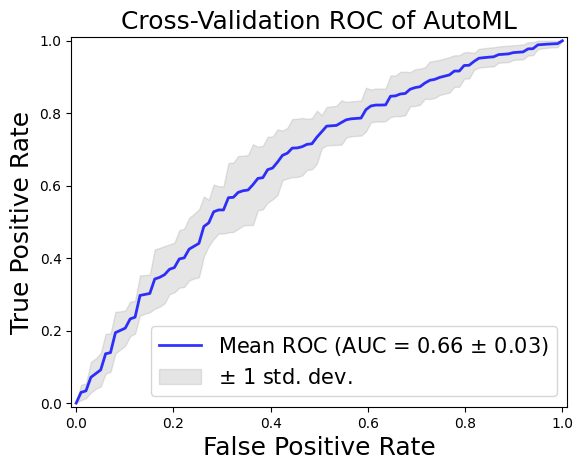

In [13]:
import logging

# Suppress FLAML INFO logging
logging.getLogger('flaml.automl').setLevel(logging.WARNING)

from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'desc' and 'y' are your input data
# Initialize AutoML for classification task
modelAutoML = AutoML(task="classification", time_budget=600, logistic_max_iter=40000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []

for i, (train, test) in enumerate(cv.split(desc, y)):
    modelAutoML.fit(desc.iloc[train], y[train], time_budget=120)
    y_hat_proba = modelAutoML.predict_proba(desc.iloc[test])[:, 1]

    fpr, tpr, thresholds = roc_curve(y[test], y_hat_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Classification report
    y_pred = modelAutoML.predict(desc.iloc[test])
    print(f"\nClassification Report for Fold {i}:\n")
    print(classification_report(y[test], y_pred))

    # Accumulate true labels and predictions
    all_true_labels.extend(y[test])
    all_predictions.extend(y_pred)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

#Using Ersilia

In [6]:
# Load your CSV file
df = pd.read_csv('../data/dilismiles_with_outcome.csv')

In [7]:
## using ersilia to change smiles to embeddings
import pandas as pd
from eosce.models import ErsiliaCompoundEmbeddings

# Assuming 'SMILES' is the column containing chemical compounds
compounds = df['smiles'].tolist()

# Initialize the ErsiliaCompoundEmbeddings model
model = ErsiliaCompoundEmbeddings()

# Create a new column for embeddings
df['embeddings'] = df['smiles'].apply(lambda x: model.transform([x])[0])

# Display the DataFrame with the new embeddings
print(df.head())

                                              smiles  outcome  \
0  [H][C@]1([S-])O[C@]([H])(CO)[C@@]([H])(O)[C@](...        1   
1  CN(CCCCCCCCCCN(C)C(=O)Oc1cccc(c1)[N+](C)(C)C)C...        1   
2   [H][C@]12Cc3ccc(OC)cc3[C@@]3(CCCC[C@]13[H])CCN2C        0   
3  [H][C@@]12CCCN1C(=O)[C@]([H])(Cc1ccccc1)N1C(=O...        0   
4  [H][C@]1(C)C[C@@]2([H])[C@]3([H])CCC4=CC(=O)C=...        0   

          CommonName                                         embeddings  
0    Aurothioglucose  [-0.098519824, 0.12393576, 0.13180989, 0.05279...  
1  DemecariumBromide  [0.015572911, 0.025008846, 0.015938658, 0.0437...  
2   Dextromethorphan  [0.0857603, 0.07983373, -0.014359435, -0.21451...  
3         Ergotamine  [0.13486916, 0.07353798, -0.14174657, -0.23422...  
4     Beclomethasone  [0.100365646, 0.038999967, -0.020612031, -0.03...  


In [8]:
y= df['outcome']

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
import numpy as np

# Assuming 'ID' column contains embedding vectors
X = np.array(df['embeddings'].values.tolist())
X.shape

(588, 1024)

In [10]:
y.shape

(588,)

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune



Classification Report for Fold 0:

              precision    recall  f1-score   support

           0       0.30      0.08      0.12        39
           1       0.67      0.91      0.77        79

    accuracy                           0.64       118
   macro avg       0.48      0.49      0.45       118
weighted avg       0.55      0.64      0.56       118



INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune



Classification Report for Fold 1:

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        39
           1       0.69      1.00      0.81        79

    accuracy                           0.69       118
   macro avg       0.84      0.54      0.48       118
weighted avg       0.79      0.69      0.59       118



INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune



Classification Report for Fold 2:

              precision    recall  f1-score   support

           0       0.86      0.15      0.26        39
           1       0.70      0.99      0.82        79

    accuracy                           0.71       118
   macro avg       0.78      0.57      0.54       118
weighted avg       0.75      0.71      0.64       118



INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune



Classification Report for Fold 3:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.68      1.00      0.81        79

    accuracy                           0.68       117
   macro avg       0.34      0.50      0.40       117
weighted avg       0.46      0.68      0.54       117



/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le


Classification Report for Fold 4:

              precision    recall  f1-score   support

           0       0.86      0.15      0.26        39
           1       0.70      0.99      0.82        78

    accuracy                           0.71       117
   macro avg       0.78      0.57      0.54       117
weighted avg       0.75      0.71      0.63       117


Average Classification Report Across All Folds:

              precision    recall  f1-score   support

           0       0.67      0.09      0.16       194
           1       0.69      0.98      0.81       394

    accuracy                           0.69       588
   macro avg       0.68      0.53      0.48       588
weighted avg       0.68      0.69      0.59       588



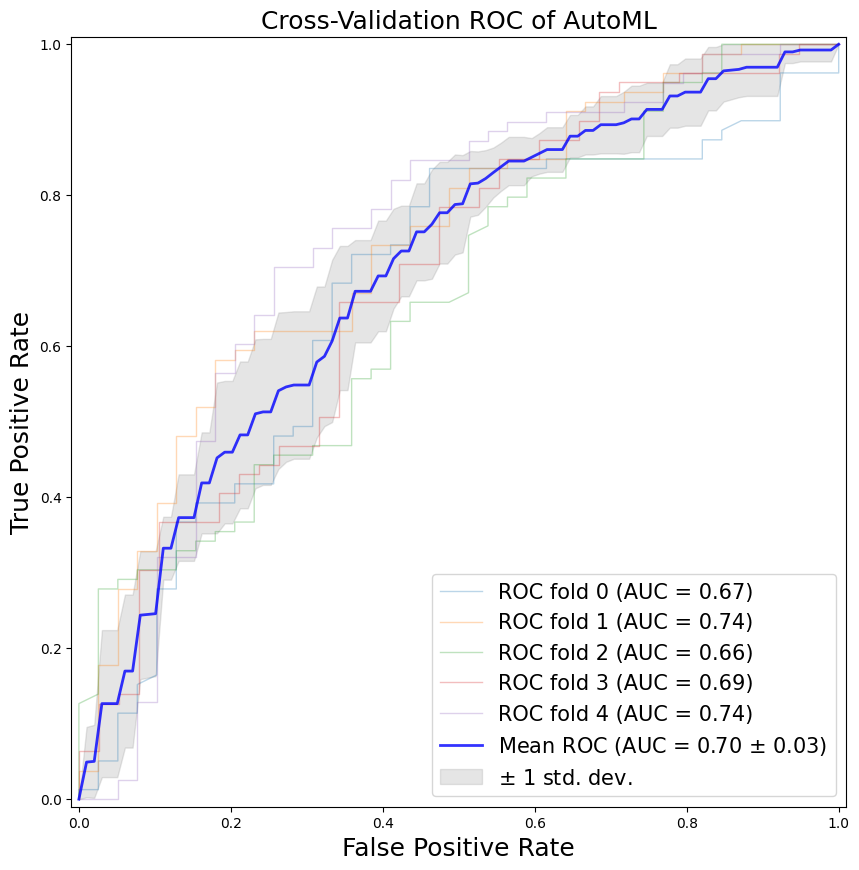

In [11]:
import warnings
import xgboost
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize AutoML for classification task
modelAutoML = AutoML(task="classification", time_budget=600, logistic_max_iter=80000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
i = 0

all_true_labels = []
all_predictions = []

for train, test in cv.split(X, y):
    modelAutoML.fit(X[train], y[train], verbose=1)
    probas_ = modelAutoML.predict_proba(X[test])[:, 1]

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Classification report
    y_pred = modelAutoML.predict(X[test])
    print(f"\nClassification Report for Fold {i}:\n")
    print(classification_report(y[test], y_pred))

    # Accumulate true labels and predictions
    all_true_labels.extend(y[test])
    all_predictions.extend(y_pred)

    i += 1

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()


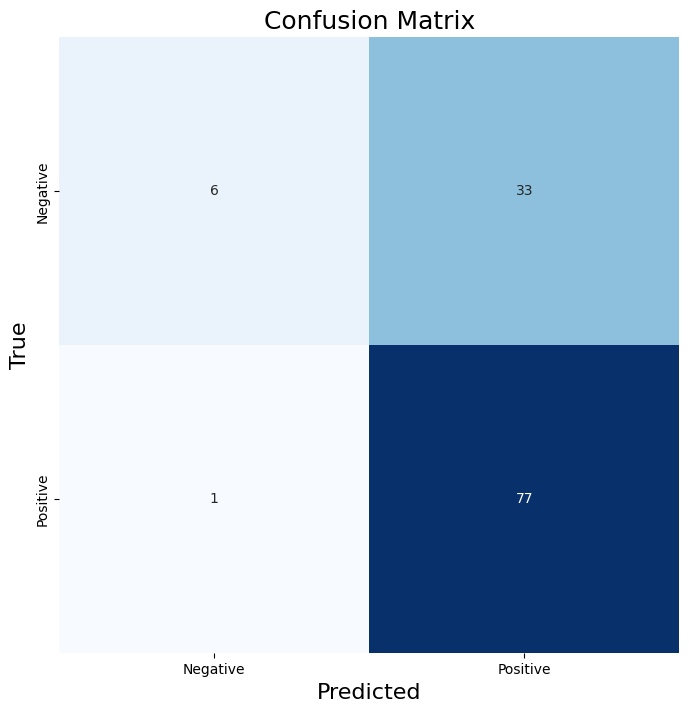

In [12]:
## confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# Assuming modelAutoML is your trained AutoML model
predictions = modelAutoML.predict(X[test])

# Get the confusion matrix
cm = confusion_matrix(y[test], predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("True", fontsize=16)
plt.title("Confusion Matrix", fontsize=18)

plt.show()

In [13]:
##save the model with AutoML_ersilia
import joblib
joblib.dump(modelAutoML, '../../checkpoints/AutoML_ersilia.joblib')

['../../checkpoints/AutoML_ersilia.joblib']

# With Morgan Fingerprints

In [ ]:
##import dependecies
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

In [ ]:
import pandas as pd
smilescsv = pd.read_csv('../data/dilismiles_with_outcome.csv', names=['smiles'])

In [ ]:
# Add RDKit molecules column and filter out invalid molecules
smilescsv['mol'] = smilescsv['smiles'].apply(lambda x: Chem.MolFromSmiles(x) if x is not None else None)
smilescsv = smilescsv.dropna(subset=['mol'])

# Generate Morgan Fingerprints
smilescsv['morgan_fps'] = smilescsv['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))

In [ ]:
max_length = max(len(fp.GetOnBits()) for fp in smilescsv['morgan_fps'])
X = np.array([list(fp.GetOnBits()) + [0] * (max_length - len(fp.GetOnBits())) for fp in smilescsv['morgan_fps']])

In [ ]:
print(X)

[[  3  13  34 ...   0   0   0]
 [ 15  24  33 ...   0   0   0]
 [  4  33  34 ...   0   0   0]
 ...
 [ 80  94 128 ...   0   0   0]
 [ 33  80  97 ...   0   0   0]
 [ 33  41  58 ...   0   0   0]]


In [ ]:
X.shape

(588, 123)

In [ ]:
y.shape

(588,)

2024-01-13 23:29:49,401	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune



Classification Report for Fold 0:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.67      1.00      0.80        79

    accuracy                           0.67       118
   macro avg       0.33      0.50      0.40       118
weighted avg       0.45      0.67      0.54       118



/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le


Classification Report for Fold 1:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.67      1.00      0.80        79

    accuracy                           0.67       118
   macro avg       0.33      0.50      0.40       118
weighted avg       0.45      0.67      0.54       118



/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le


Classification Report for Fold 2:

              precision    recall  f1-score   support

           0       0.25      0.18      0.21        39
           1       0.64      0.73      0.69        79

    accuracy                           0.55       118
   macro avg       0.45      0.46      0.45       118
weighted avg       0.51      0.55      0.53       118



INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune



Classification Report for Fold 3:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.68      1.00      0.81        79

    accuracy                           0.68       117
   macro avg       0.34      0.50      0.40       117
weighted avg       0.46      0.68      0.54       117



/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le


Classification Report for Fold 4:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.67      1.00      0.80        78

    accuracy                           0.67       117
   macro avg       0.33      0.50      0.40       117
weighted avg       0.44      0.67      0.53       117


Average Classification Report Across All Folds:

              precision    recall  f1-score   support

           0       0.25      0.04      0.06       194
           1       0.67      0.95      0.78       394

    accuracy                           0.65       588
   macro avg       0.46      0.49      0.42       588
weighted avg       0.53      0.65      0.54       588



/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

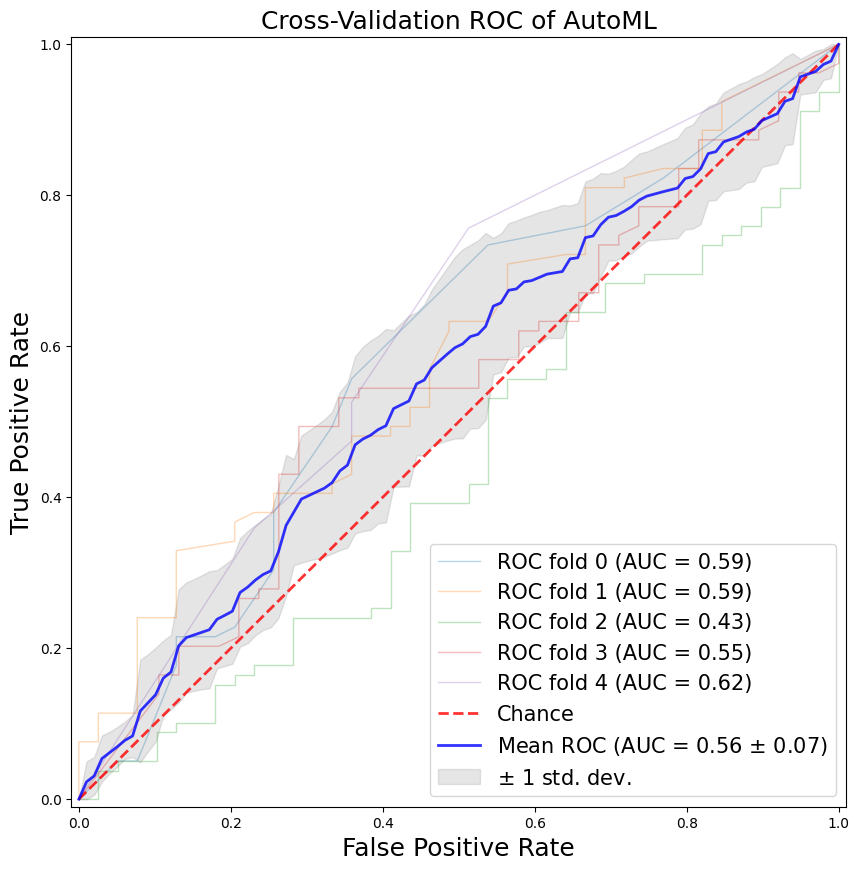

<Figure size 640x480 with 0 Axes>

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report
import numpy as np
import matplotlib.pyplot as plt
import ray

ray.init(ignore_reinit_error=True)


warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Assuming you have X as a list of lists
# No padding for non-sequential data
X = np.array(X)  # Convert X to numpy array if it's not already
y = np.array(y)  # Convert y to numpy array if it's not already

# Initialize AutoML for classification task
modelAutoML = AutoML(task="classification", time_budget=600, logistic_max_iter=40000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
i = 0

# Initialize lists for accumulating true labels and predictions
all_true_labels = []
all_predictions = []

for train, test in cv.split(X, y):
    modelAutoML.fit(X[train], y[train], verbose=-1)
    probas_ = modelAutoML.predict_proba(X[test])[:, 1]

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Classification report
    y_pred = modelAutoML.predict(X[test])
    print(f"\nClassification Report for Fold {i}:\n")
    print(classification_report(y[test], y_pred))

    # Accumulate true labels and predictions
    all_true_labels.extend(y[test])
    all_predictions.extend(y_pred)

    i += 1

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()
plt.savefig("../figures/morgan_automl_roc_plot.png")

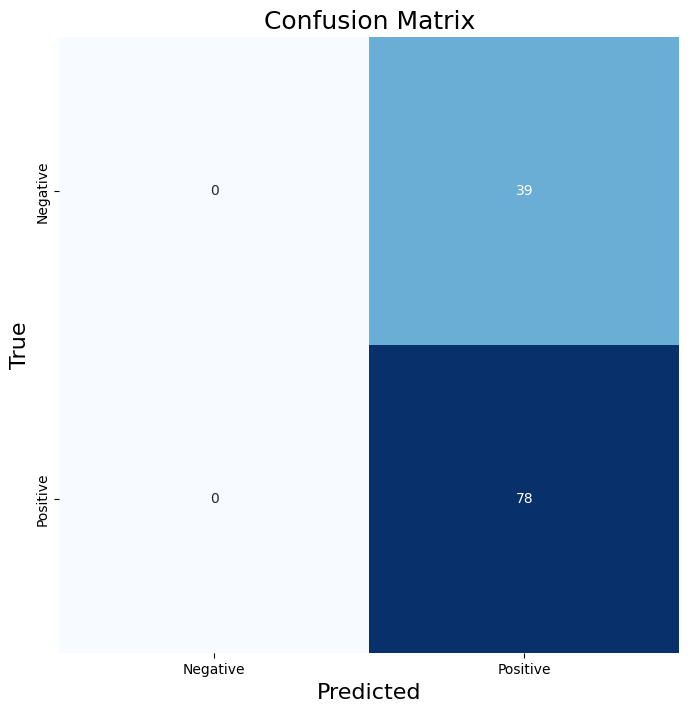

<Figure size 640x480 with 0 Axes>

In [ ]:
## confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# Assuming modelAutoML is your trained AutoML model
predictions = modelAutoML.predict(X[test])

# Get the confusion matrix
cm = confusion_matrix(y[test], predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("True", fontsize=16)
plt.title("Confusion Matrix", fontsize=18)

plt.show()
plt.savefig("../figures/morgan_automl_confusion_matrix_plot.png")

In [ ]:
##save the model with AutoML_ersilia
import joblib
joblib.dump(modelAutoML, '../../checkpoints/AutoML_morgan_fp.joblib')

['../../checkpoints/AutoML_morgan_fp.joblib']

# AutoGluon Model
Basic Autogluon Example

In [1]:
import pandas as pd
from rdkit import Chem
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
##Autogluon with padel
smilescsv = pd.read_csv('../data/dilismiles.csv', names = ['col_smiles'])
data = pd.read_csv('../data/dili_padel_2d.csv')
dataframe = pd.DataFrame(data)
desc = pd.DataFrame(dataframe.iloc[:, 3:])

/tmp/ipykernel_2724741/3149710005.py:5: DtypeWarning: Columns (423,424,425,426,427,428,429,430,431,477,478,479,480,481,482,483,484,485,540,541,542,543,544,545,546,547,548,603,604,605,606,607,608,609,610,611,1012,1013,1050,1052,1074,1083,1084,1121,1123,1145,1217,1218,1219,1220,1222,1223,1224,1226,1227,1229) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/dili_padel_2d.csv')


# Install Autogluon

In [5]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [6]:
X = TabularDataset('../data/dili_padel_2d.csv')
print(X.head(), X.shape)

               ID         CommonName  Outcome  nAcid  naAromAtom  nAromBond  \
0  AUTOGEN_dili_1    Aurothioglucose        1      0           0          0   
1  AUTOGEN_dili_2  DemecariumBromide        1      0          12         12   
2  AUTOGEN_dili_3   Dextromethorphan        0      0           6          6   
3  AUTOGEN_dili_4         Ergotamine        0      0          15         16   
4  AUTOGEN_dili_5     Beclomethasone        0      0           0          0   

   nB  nN  nO  nS  ...       AMW      WTPT1     WTPT2      WTPT3      WTPT4  \
0   0   0   5   1  ...  8.479683  23.078977  1.923248  15.422349  12.919448   
1   0   4   4   0  ...  6.047814  78.841924  1.971048  24.051089  11.127775   
2   0   1   1   0  ...  6.026525  42.041518  2.102076   6.134966   2.806398   
3   0   5   5   0  ...  7.452100  90.264234  2.099168  30.004012  13.475249   
4   0   0   5   0  ...  7.160883  56.562478  2.020089  15.115392  12.515759   

       WTPT5  WPATH  WPOL  XLogP  Zagreb  
0   0.0

In [7]:
y = X['Outcome']
print(type(y),y.shape)

<class 'pandas.core.series.Series'> (588,)


In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

In [10]:
X.shape

(588, 1447)

In [11]:
label = 'Outcome'

In [12]:
fit_args = {}
fit_args['time_limit'] = 1200
predictor = TabularPredictor(label=label).fit(x_train,presets="best_quality", **fit_args)
performance = predictor.evaluate(x_test)

No path specified. Models will be saved in: "AutogluonModels/ag-20240117_081940"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 1200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240117_081940/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20240117_081940/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.

In [13]:
print(performance)

{'accuracy': 0.7796610169491526, 'balanced_accuracy': 0.6637004078605858, 'mcc': 0.37672523793906193, 'roc_auc': 0.7122728958101594, 'f1': 0.8586956521739131, 'precision': 0.8144329896907216, 'recall': 0.9080459770114943}


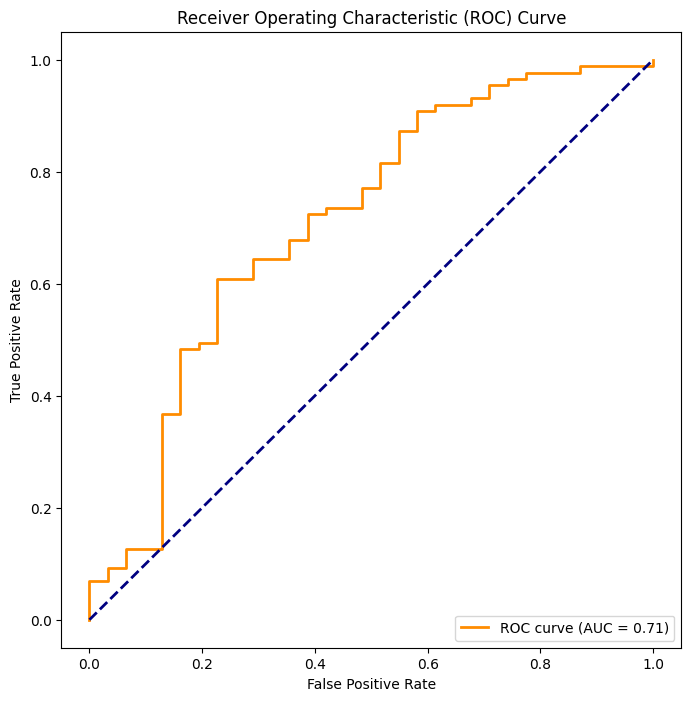

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming 'outcome' is the target column in your dataset
y_true = x_test['Outcome']
y_scores = predictor.predict_proba(x_test.drop(columns=[label])).iloc[:, 1]  # Probability of positive class

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


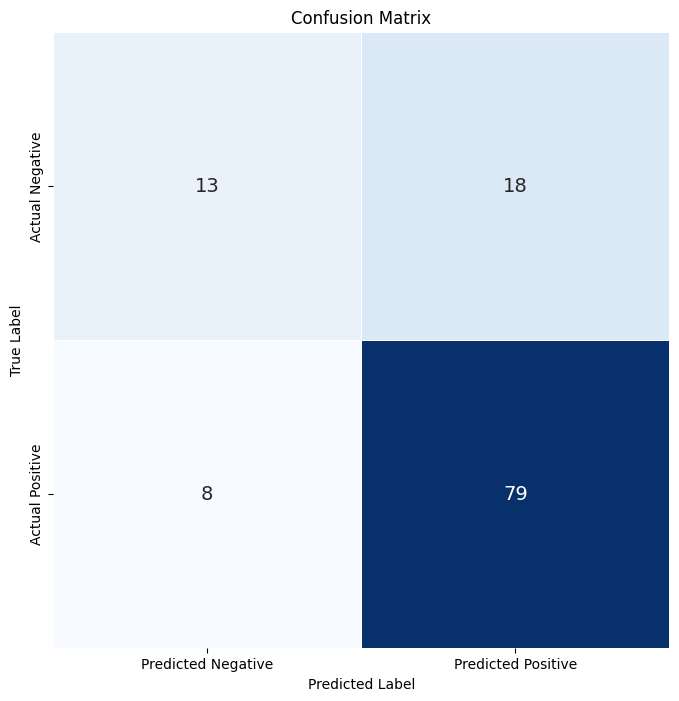

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred_binary = (y_scores > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, square=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Autogluon with Morgan fingerprints

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [ ]:
data = pd.read_csv('../data/dilismiles_with_outcome.csv')
dataframe = pd.DataFrame(data)
desc = pd.DataFrame(dataframe)

In [ ]:
import pandas as pd
from rdkit.Chem import AllChem, MolFromSmiles

# Assuming 'col_smiles' is the column containing SMILES strings
data['mol'] = data['smiles'].apply(lambda x: MolFromSmiles(x))
# Generate Morgan fingerprints
data['morgan_fp'] = data['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))
# Convert Morgan fingerprints to a binary vector representation
data['morgan_vec'] = [list(fp.ToBitString()) for fp in data['morgan_fp']]

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'morgan_vec' is the column containing binary vector representations
X = data['morgan_vec'].tolist()
y = data['outcome']


In [ ]:
# Flatten the lists in 'morgan_vec' column
X_flattened = pd.DataFrame(X).apply(lambda x: x.explode()).reset_index(drop=True)

# Combine flattened features with target variable
df = pd.concat([X_flattened, pd.Series(y, name='outcome')], axis=1)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

fit_args = {}
fit_args['time_limit'] = 1200
label = 'outcome'  # Replace with the actual target column name

# Create and train the AutoGluon TabularPredictor
predictor = TabularPredictor(label=label)
predictor.fit(train_data=train_df, presets="best_quality", num_bag_folds=5, **fit_args)

No path specified. Models will be saved in: "AutogluonModels/ag-20240116_002025"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 1200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240116_002025/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20240116_002025/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.

[1000]	valid_set's binary_error: 0.216867


	0.717	 = Validation score   (accuracy)
	1.75s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 120.76s of the 220.05s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.7386	 = Validation score   (accuracy)
	7.05s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 113.42s of the 212.7s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	To avoid this warning, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=1.14 to avoid the warning)
		To set the same value for all models, do the following when calling predictor.fit: `predictor.fit(..., ag_args_fit={"ag.max_memory_usage_ratio": VALUE})`
		Setting "ag.max_memory_usage_ratio" to values above 1 may result in out-of-memory errors. You may 

[1000]	valid_set's binary_error: 0.265957


	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 10: early stopping
No improvement since epoch 2: early stopping
No improvement since epoch 2: early stopping
No improvement since epoch 8: early stopping
	0.6979	 = Validation score   (accuracy)
	7.79s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 830.95s of the 830.93s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.7532	 = Validation score   (accuracy)
	16.4s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: LightGBM_r96_BAG_L1 ... Training model for up to 814.1s of the 814.08s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.7128	 = Validation score   (accuracy)
	1.75s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L1 ... Tra

In [ ]:
# Use the trained predictor to make predictions on the test set
y_pred = predictor.predict(test_df.drop(columns=[label]))

# Evaluate the performance of the model
performance = predictor.evaluate_predictions(y_true=test_df[label], y_pred=y_pred)
print(performance)

{'accuracy': 0.6271186440677966, 'balanced_accuracy': 0.5750674258315853, 'mcc': 0.17496736213265582, 'f1': 0.728395061728395, 'precision': 0.6483516483516484, 'recall': 0.8309859154929577}


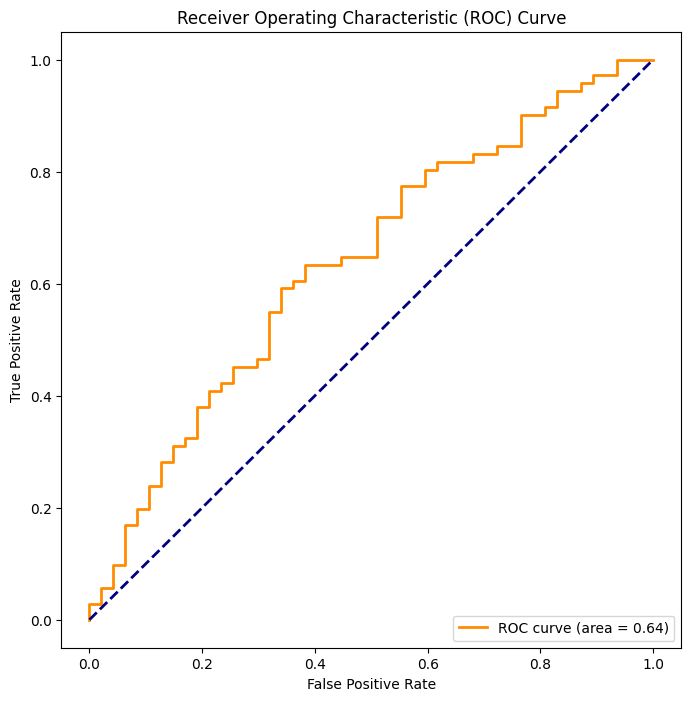

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming 'outcome' is the target column in your dataset
y_true = test_df['outcome']
y_scores = predictor.predict_proba(test_df.drop(columns=[label])).iloc[:, 1]  # Probability of positive class

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


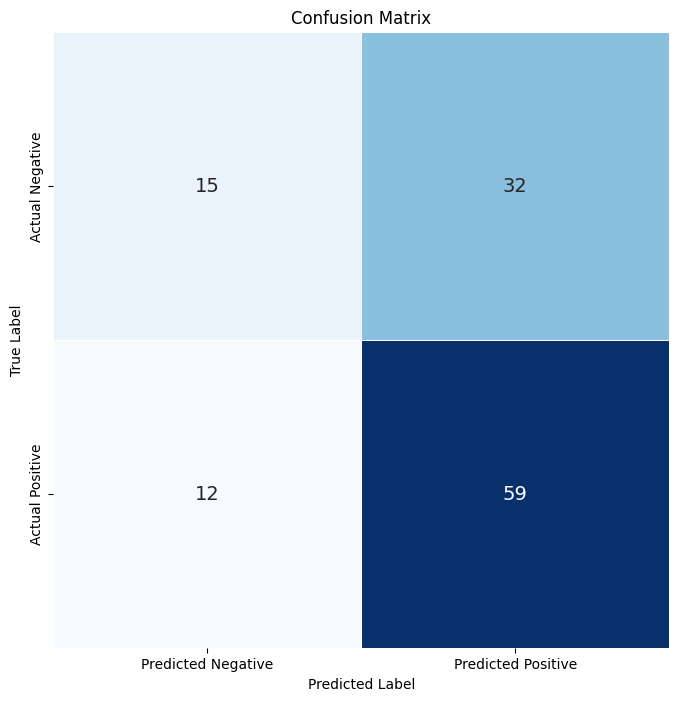

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred_binary = (y_scores > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, square=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Autogluon with Ersilia embeddings

In [1]:
import pandas as pd
from eosce.models import ErsiliaCompoundEmbeddings
from sklearn.model_selection import train_test_split

import pandas as pd

# Load only 'smiles' and 'Outcome' columns from the CSV file
df = pd.read_csv('../data/dilismiles_with_outcome.csv', usecols=['smiles', 'outcome'])

# Display the first few rows of the DataFrame
print(df.head())

# Assuming 'SMILES' is the column containing chemical compounds
compounds = df['smiles'].tolist()
# Initialize the ErsiliaCompoundEmbeddings model
model = ErsiliaCompoundEmbeddings()

                                              smiles  outcome
0  [H][C@]1([S-])O[C@]([H])(CO)[C@@]([H])(O)[C@](...        1
1  CN(CCCCCCCCCCN(C)C(=O)Oc1cccc(c1)[N+](C)(C)C)C...        1
2   [H][C@]12Cc3ccc(OC)cc3[C@@]3(CCCC[C@]13[H])CCN2C        0
3  [H][C@@]12CCCN1C(=O)[C@]([H])(Cc1ccccc1)N1C(=O...        0
4  [H][C@]1(C)C[C@@]2([H])[C@]3([H])CCC4=CC(=O)C=...        0


In [2]:
# Create a new column for embeddings
df['embeddings'] = df['smiles'].apply(lambda x: model.transform([x])[0])

In [3]:
print(df)

                                                smiles  outcome  \
0    [H][C@]1([S-])O[C@]([H])(CO)[C@@]([H])(O)[C@](...        1   
1    CN(CCCCCCCCCCN(C)C(=O)Oc1cccc(c1)[N+](C)(C)C)C...        1   
2     [H][C@]12Cc3ccc(OC)cc3[C@@]3(CCCC[C@]13[H])CCN2C        0   
3    [H][C@@]12CCCN1C(=O)[C@]([H])(Cc1ccccc1)N1C(=O...        0   
4    [H][C@]1(C)C[C@@]2([H])[C@]3([H])CCC4=CC(=O)C=...        0   
..                                                 ...      ...   
583                             OC1C(O)C(O)C(O)C(O)C1O        0   
584                                           OCC(S)CS        1   
585  OCCNCCNc1ccc(NCCNCCO)c2C(=O)c3c(O)ccc(O)c3C(=O...        1   
586  [H]C([H])([H])C([H])([H])N(C(=S)SSC(=S)N(C([H]...        1   
587  CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC...        1   

                                            embeddings  
0    [-0.098519824, 0.12393576, 0.13180989, 0.05279...  
1    [0.015572911, 0.025008846, 0.015938658, 0.0437...  
2    [0.0857603, 0.07983

In [4]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['embeddings'].tolist(), df['outcome'].tolist(), test_size=0.2, random_state=42)

In [5]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor

# Convert X_train to a list
X_train_list = [embedding.flatten().tolist() for embedding in X_train]

# Convert X_test to a list
X_test_list = [embedding.flatten().tolist() for embedding in X_test]

# Convert lists to tuples
X_train_tuples = [tuple(embedding) for embedding in X_train_list]
X_test_tuples = [tuple(embedding) for embedding in X_test_list]

# Combine embeddings with labels for training data
df_train = pd.DataFrame({'embeddings': X_train_tuples, 'outcome': y_train})

label = 'outcome'
fit_args = {}
fit_args['time_limit'] = 1200

predictor = TabularPredictor(label=label)
predictor.fit(df_train, presets="best_quality", **fit_args)

# Convert X_test to a DataFrame
df_test = pd.DataFrame({'embeddings': X_test_tuples})

# Now you can predict using the trained model on the test data
predictions = predictor.predict(df_test)



No path specified. Models will be saved in: "AutogluonModels/ag-20240117_085823"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 1200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240117_085823/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20240117_085823/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.

In [10]:
#Print performance
df_test_with_labels = pd.DataFrame({'outcome': y_test, 'embeddings': X_test_tuples})
predictions = predictor.predict(df_test_with_labels)

# Evaluate the predictions
performance = predictor.evaluate(df_test_with_labels, silent=True)
print(performance)


{'accuracy': 0.6016949152542372, 'balanced_accuracy': 0.5, 'mcc': 0.0, 'roc_auc': 0.5, 'f1': 0.7513227513227513, 'precision': 0.6016949152542372, 'recall': 1.0}


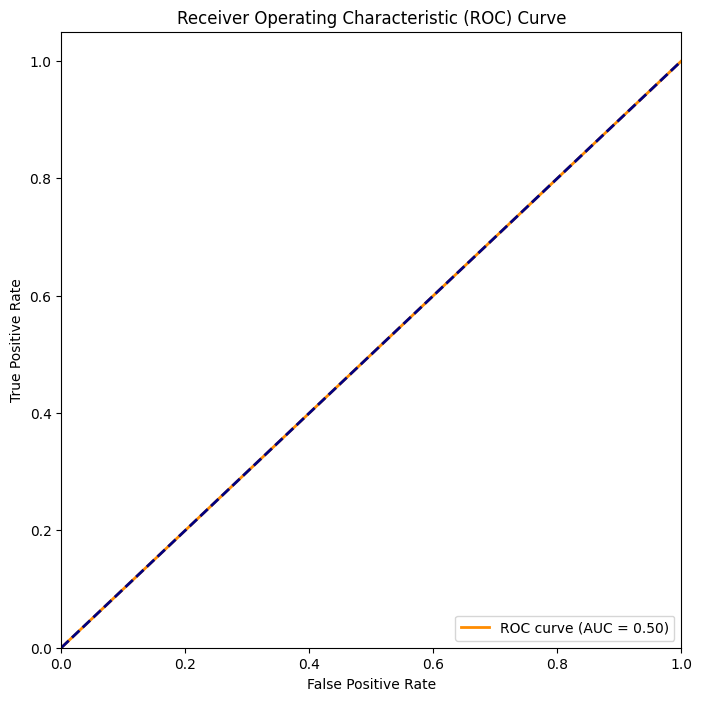

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'y_test' is your ground truth labels
df_test_with_labels = pd.DataFrame({'outcome': y_test, 'embeddings': X_test_tuples})

# Now you can predict using the trained model on the test data
predictions = predictor.predict_proba(df_test_with_labels)

# Get the predicted probabilities for the positive class
y_scores = predictions.iloc[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(df_test_with_labels['outcome'], y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig("../figures/ersilia_AutoGluon_auroc_plot.png")

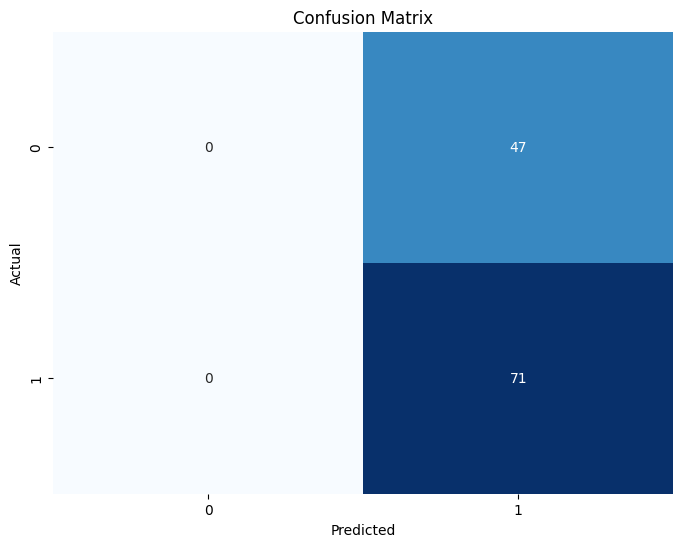

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Assuming 'y_test' is your ground truth labels
df_test_with_labels = pd.DataFrame({'outcome': y_test, 'embeddings': X_test_tuples})

# Now you can predict using the trained model on the test data
predictions = predictor.predict(df_test_with_labels)

# Get the confusion matrix
conf_matrix = confusion_matrix(df_test_with_labels['outcome'], predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig("../figures/ersilia_AutoGluon_confusion_matrix.png")

In [1]:
## Autogluon with padelpy descriptors

In [19]:
import pandas as pd
from padelpy import from_smiles

# Read the CSV file with SMILES and outcome columns
data = pd.read_csv('../data/dilismiles_with_outcome.csv')


data_subset = data.head(337)

# Convert SMILES column to a list
smiles_list = data_subset['smiles'].tolist()

# Calculate descriptors for each SMILES string
descriptors_list = from_smiles(smiles_list)

# Convert descriptors list to a DataFrame
descriptors_df = pd.DataFrame(descriptors_list)

# Add the outcome column to the descriptors DataFrame
descriptors_df['outcome'] = data_subset['outcome']

# Save the descriptors of the first 10 rows to a new CSV file
output_csv_file = '../data/padel_descriptors.csv'
descriptors_df.to_csv(output_csv_file, index=False)

In [5]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [7]:
X = TabularDataset('../data/padel_descriptors.csv')
print(X.head(), X.shape)

   nAcid   ALogP     ALogp2       AMR       apol  naAromAtom  nAromBond  \
0      0 -2.0531   4.215220   33.3588  24.804723           0          0   
1      0 -4.5182  20.414131   95.8764  98.601236          12         12   
2      0 -0.5910   0.349281   53.9015  50.251825           6          6   
3      0 -2.5214   6.357458   97.3820  90.927755          15         16   
4      0 -0.6794   0.461584  106.0384  64.246997           0          0   

   nAtom  nHeavyAtom  nH  ...  P2s  E1s  E2s  E3s  Ts  As  Vs  Ks  Ds  outcome  
0     23          12  11  ...  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN        1  
1     92          40  52  ...  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN        1  
2     45          20  25  ...  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN        0  
3     78          43  35  ...  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN        0  
4     57          28  29  ...  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN        0  

[5 rows x 1876 columns] (337, 1876)


In [8]:
y = X['outcome']
print(type(y),y.shape)

<class 'pandas.core.series.Series'> (337,)


In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

In [10]:
X.shape

(337, 1876)

In [11]:
label='outcome'

In [26]:
fit_args = {}
fit_args['time_limit'] = 90

# Use the TabularPredictor with specified label and eval_metric
predictor = TabularPredictor(label=label).fit(x_train,presets="best_quality", refit_full=True, **fit_args) 
performance = predictor.evaluate(x_test)

No path specified. Models will be saved in: "AutogluonModels/ag-20240120_105708"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 90 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240120_105708/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 38 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 52 seconds.
Starting full fit now with num_stack_levels 

In [25]:
print(performance)

{'accuracy': 0.7647058823529411, 'balanced_accuracy': 0.6862745098039216, 'mcc': 0.37254901960784315, 'roc_auc': 0.750865051903114, 'f1': 0.8431372549019607, 'precision': 0.8431372549019608, 'recall': 0.8431372549019608}


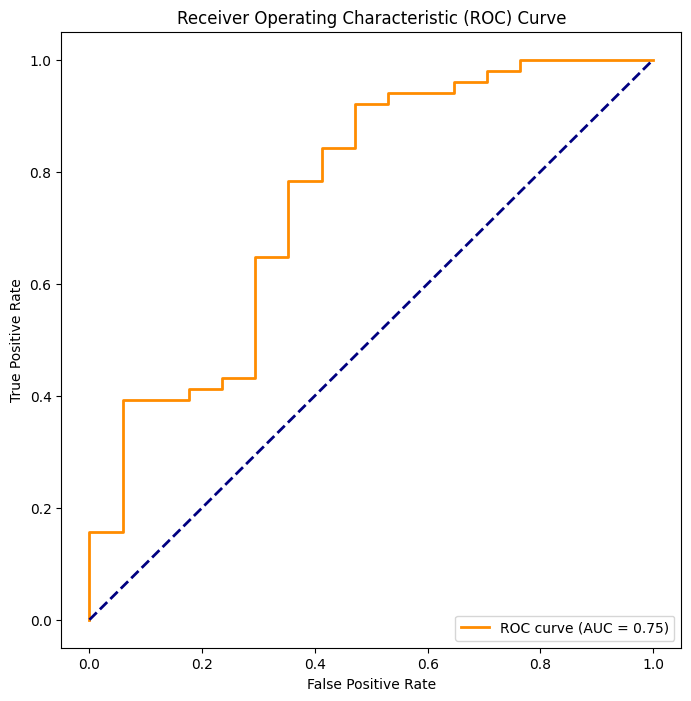

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming 'outcome' is the target column in your dataset
y_true = x_test['outcome']
y_scores = predictor.predict_proba(x_test.drop(columns=[label])).iloc[:, 1]  # Probability of positive class

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


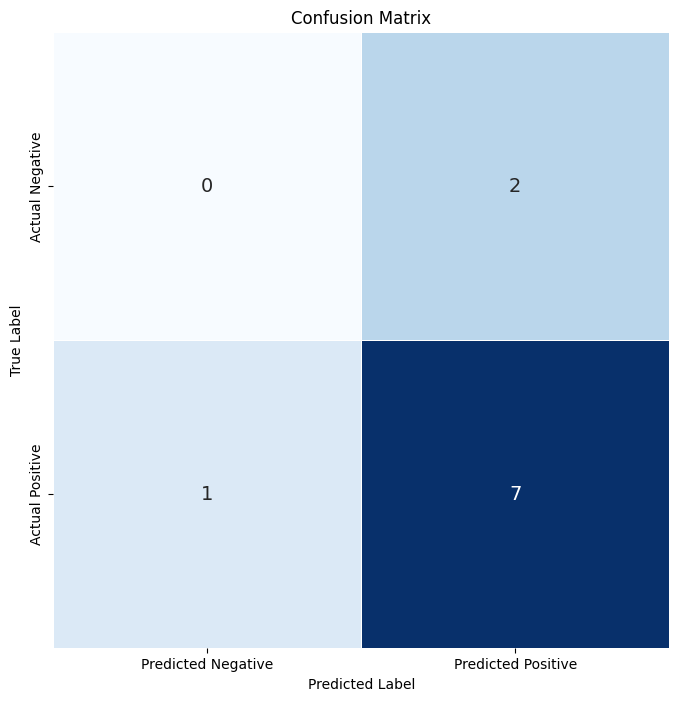

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred_binary = (y_scores > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, square=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()